In [65]:
#Importing Python modules

#Stuff for making directories and finding files
import glob, os, sys
from os import listdir
from os.path import isfile, join
import fnmatch

#Stuff for doing math and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec
from scipy.signal import savgol_filter

#stuff for getting FFI data from MAST
import astropy
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.wcs import WCS
from astropy.io import fits

#in case there are WiFi issues, these may help
from urllib.error import HTTPError
import requests

#stuff for detecting periodic transit events
from transitleastsquares import catalog_info
from transitleastsquares import period_grid
from transitleastsquares import transitleastsquares

#No one likes to see warnings (Feel free to comment this out if you do!)

import warnings
# warnings.filterwarnings(action='once') #useful to see a warning once but that's it
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

# for detrending
import wotan
from wotan import flatten

In [69]:
# Custom Python functions

# Based on information from the Data Release Notes
# https://archive.stsci.edu/tess/tess_drn.html
def momentumdump_check(SectorNum):
    SectorNum=float(SectorNum)
    if SectorNum==1 or SectorNum==2 or SectorNum==3 or SectorNum==4:
        mdumps=2.5
        if SectorNum==1:
            #orbit start times
            t_0 = 1354.10102
            t_1 = 1368.59406
        if SectorNum==2:
            #orbit start times
            t_0 = 1354.10102
            t_1 = 1368.59406
        if SectorNum==3:
            #orbit start times
            t_0 = 1382.03987
            t_1 = 1396.60497
        if SectorNum==4:
            #orbit start times
            t_0 = 1410.89974
            t_1 = 1424.54897
            
                
    elif SectorNum==5:
        mdumps=3.0
        #orbit start times
        t_0 = 1437.82566
        t_1 = 1451.54898 
            
    elif SectorNum==6 or SectorNum==7 or SectorNum==8 or SectorNum==9 or SectorNum==10 or SectorNum==11 or SectorNum==12:
        mdumps=3.125
        if SectorNum==6:
            #orbit start times
            t_0 = 1465.21262
            t_1 = 1478.11304
        if SectorNum==7:
            #orbit start times
            t_0 = 1491.62553
            t_1 = 1504.69775
        if SectorNum==8:
            #orbit start times
            t_0 = 1517.34150
            t_1 = 1530.25816
        if SectorNum==9:
            #orbit start times
            t_0 = 1543.21648
            t_1 = 1557.00080
        if SectorNum==10:
            #orbit start times
            t_0 = 1569.43176
            t_1 = 1582.76231
        if SectorNum==11:
            #orbit start times
            t_0 = 1596.77203
            t_1 = 1610.77620
        if SectorNum==12:
            #orbit start times
            t_0 = 1624.94979
            t_1 = 1640.03312
    elif SectorNum==13: 
        mdumps=3.375
        #orbit start times
        t_0 = 1653.91505
        t_1 = 1668.61921
        
    elif SectorNum==14:
        mdumps=4.4
        #orbit start times
        t_0 = 1683.34838
        t_1 = 1697.33865       
        
    return mdumps,t_0,t_1


# this will remove regions of high scatter or when Earth/Moon (EM) is in field of view
def momentumdump_removal(SectorNum,Camera,CCD,before_after_in_minutes, time, flux, flux2, flux_error):
    SectorNum=float(SectorNum)
    if SectorNum==1:
        jittermask = (time < 1347) | (time > 1350)
        mdumps=2.5
        t2,f2a,f2b,fe2=time[jittermask], flux[jittermask],flux2[jittermask], flux_error[jittermask]
        #orbit start times
        t_0 = 1325.29278
        t_1 = 1339.65310
        if Camera==1:
            EM_glintmask = (t2 < t2[-1]) | (t2 > (t2[-1]-2)) #last 2 days no good
            t2,f2a,f2b,fe2=t2[EM_glintmask], f2a[EM_glintmask],f2b[EM_glintmask], fe2[EM_glintmask]
        else:
            t2,f2a,f2b,fe2 = t2,f2a,f2b,fe2
                
    if SectorNum==2:
        mdumps=2.5
        t2,f2a,f2b,fe2=time,flux,flux2,flux_error
        #orbit start times
        t_0 = 1354.10102
        t_1 = 1368.59406
        
    if SectorNum==3:
        jittermask = (time < 1382) | (time > 1385)
        mdumps=2.5

        t2,f2a,f2b,fe2=time[jittermask], flux[jittermask],flux2[jittermask], flux_error[jittermask]
        #orbit start times
        t_0 = 1382.03987
        t_1 = 1396.60497
        
    if SectorNum==4:
        jittermask = (time > 1413) | (time < 1436.85)
        mdumps=2.5
        t2,f2a,f2b,fe2=time[jittermask], flux[jittermask],flux2[jittermask], flux_error[jittermask]
        
        jittermask = (time < 1418.53691) | (time > 1424.5) #anomaly
        t2,f2a,f2b,fe2=t2[jittermask], f2a[jittermask],f2b[jittermask], fe2[jittermask]
         
        #orbit start times
        t_0 = 1410.89974
        t_1 = 1424.54897
        if Camera==1: 
            EM_glintmask = (t2 < 1422.2297) | (t2 > 1423.502) 
            t3,f3a,f3b,fe3=t2[EM_glintmask], f2a[EM_glintmask],f2b[EM_glintmask], fe2[EM_glintmask]
            
            EM_glintmask2 = (t3 < 1436.1047) | (t3 > 1436.8353) 
            t2,f2a,f2b,fe2=t3[EM_glintmask2], f3a[EM_glintmask2],f3b[EM_glintmask2], fe3[EM_glintmask2]
        else:
            t2,f2a,f2b,fe2 = t2,f2a,f2b,fe2            
            
    elif SectorNum==5:
        mdumps=3.0
        t2,f2a,f2b,fe2=time,flux,flux2,flux_error  
        #orbit start times
        t_0 = 1437.82566
        t_1 = 1451.54898 
        if Camera==1: 
            EM_glintmask = (t2 < 1463.93945) | (t2 > 1464.25) 
            t3,f3a,f3b,fe3=t2[EM_glintmask], f2a[EM_glintmask],f2b[EM_glintmask], fe2[EM_glintmask]
        else:
            t2,f2a,f2b,fe2 = t2,f2a,f2b,fe2
            
    elif SectorNum==6 or SectorNum==7:
        mdumps=3.125
        t2,f2a,f2b,fe2=time,flux,flux2,flux_error  
        if SectorNum==6:
            #orbit start times
            t_0 = 1465.21262
            t_1 = 1478.11304
        elif SectorNum==7:
            #orbit start times
            t_0 = 1491.62553
            t_1 = 1504.69775
            
    if SectorNum==8:
        mdumps=3.125
        t2,f2a,f2b,fe2=time,flux,flux2,flux_error  
        
        EM_glintmask = (t2 < 1516) | (t2 > 1517.75) #earth glint at start of orbit
        t3,f3a,f3b,fe3=t2[EM_glintmask], f2a[EM_glintmask],f2b[EM_glintmask], fe2[EM_glintmask]
        
        EM_glintmask2 = (t3 < 1529) | (t3 > 1535.25) #earth glint at start of orbit
        t2,f2a,f2b,fe2=t3[EM_glintmask2], f3a[EM_glintmask2],f3b[EM_glintmask2], fe3[EM_glintmask2]
        #orbit start times
        t_0 = 1517.34150
        t_1 = 1530.25816
        
    if SectorNum==9:
        t2,f2a,f2b,fe2=time,flux,flux2,flux_error  
        mdumps=3.125

        EM_glintmask = (t2 < 1542.21) | (t2 > 1544.0) #earth glint at start of orbit
        t3,f3a,f3b,fe3=t2[EM_glintmask], f2a[EM_glintmask],f2b[EM_glintmask], fe2[EM_glintmask]
        
        EM_glintmask2 = (t3 < 1556.0) | (t3 > 1557.75) #earth glint at start of orbit
        t2,f2a,f2b,fe2=t3[EM_glintmask2], f3a[EM_glintmask2],f3b[EM_glintmask2], fe3[EM_glintmask2]
        #orbit start times
        t_0 = 1543.21648
        t_1 = 1557.00080
        
    if SectorNum==10:
        t2,f2a,f2b,fe2=time,flux,flux2,flux_error  
        mdumps=3.125

        EM_glintmask = (t2 < (1569.43-1)) | (t2 > (1571.0)) #earth glint at start of orbit
        t3,f3a,f3b,fe3=t2[EM_glintmask], f2a[EM_glintmask],f2b[EM_glintmask], fe2[EM_glintmask]
        
        EM_glintmask2 = (t3 < (1582.76-1)) | (t3 > (1584.5)) #earth glint at start of orbit
        t2,f2a,f2b,fe2=t3[EM_glintmask2], f3a[EM_glintmask2],f3b[EM_glintmask2], fe3[EM_glintmask2]
        #orbit start times
        t_0 = 1569.43176
        t_1 = 1582.76231
        
    if SectorNum==11:
        t2,f2a,f2b,fe2=time,flux,flux2,flux_error  
        mdumps=3.125
        EM_glintmask = (t2 < (1596.77-1)) | (t2 > (1599)) #earth glint at start of orbit
        t3,f3a,f3b,fe3=t2[EM_glintmask], f2a[EM_glintmask],f2b[EM_glintmask], fe2[EM_glintmask]
        
        EM_glintmask2 = (t3 < (1610)) | (t3 > (1613.75)) #earth glint at start of orbit
        t2,f2a,f2b,fe2=t3[EM_glintmask2], f3a[EM_glintmask2],f3b[EM_glintmask2], fe3[EM_glintmask2]
        #orbit start times
        t_0 = 1596.77203
        t_1 = 1610.77620
        
    if SectorNum==12:
        t2,f2a,f2b,fe2=time,flux,flux2,flux_error  
        mdumps=3.125  
        EM_glintmask = (t2 < (1624.949-1)) | (t2 > (1624.949+0.75)) #earth glint at start of orbit
        t3,f3a,f3b,fe3=t2[EM_glintmask], f2a[EM_glintmask],f2b[EM_glintmask], fe2[EM_glintmask]
        
        EM_glintmask2 = (t3 < (1640.03-1)) | (t3 > (1640.03+0.75)) #earth glint at start of orbit
        t2,f2a,f2b,fe2=t3[EM_glintmask2], f3a[EM_glintmask2],f3b[EM_glintmask2], fe3[EM_glintmask2]
        #orbit start times
        t_0 = 1624.94979
        t_1 = 1640.03312
        
    if SectorNum==13: 
        jittermask = (time < 1665.2983) | (time > 1665.3501) 
        mdumps=3.375
        t2,f2a,f2b,fe2=time[jittermask], flux[jittermask],flux2[jittermask], flux_error[jittermask]
        #orbit start times
        t_0 = 1653.91505
        t_1 = 1668.61921
        
        EM_glintmask = (t2 < (1653.915-1)) | (t2 > (1653.915+0.75)) #earth glint at start of orbit
        t3,f3a,f3b,fe3=t2[EM_glintmask], f2a[EM_glintmask],f2b[EM_glintmask], fe2[EM_glintmask]
        
        EM_glintmask2 = (t3 < (1668.61903-1)) | (t3 > (1668.619+0.75)) #earth glint at start of orbit
        t2,f2a,f2b,fe2=t3[EM_glintmask2], f3a[EM_glintmask2],f3b[EM_glintmask2], fe3[EM_glintmask2]
            
    if SectorNum==14:
        mdumps=4.4
        t2,f2a,f2b,fe2=time,flux,flux2,flux_error  
        #orbit start times
        t_0 = 1683.34838
        t_1 = 1697.33865
        
        
    
    Num_mdumps = int(np.round((t2[-1]-t2[0])/mdumps,2))
    before_after = before_after_in_minutes/(60.0*24.0) # in days
    
    tt,ff1,ff2,fefe = t2,f2a,f2b,fe2
    
    for N in range(Num_mdumps):
        #first half of data
        time_mdump = tt[0]+(N/2-0.5)*mdumps
        minus = time_mdump - before_after
        plus  = time_mdump + before_after
        mask_mdump = (tt < minus) | (tt > plus)
        
        tt,ff1,ff2,fefe = tt[mask_mdump], ff1[mask_mdump], ff2[mask_mdump], fefe[mask_mdump]
        
        #second half of data
        time_mdump = t_1+(N/2)*mdumps
        minus = time_mdump - before_after
        plus  = time_mdump + before_after
        mask_mdump = (tt < minus) | (tt > plus)
        
        tt,ff1,ff2,fefe = tt[mask_mdump], ff1[mask_mdump], ff2[mask_mdump], fefe[mask_mdump]



    # Identify outliers
    m = np.ones(len(ff2), dtype=bool)
    cad = tt[1]-tt[0] #candence between 2 data points. For TESS should all be roughly the same. 
    
    #now let's define a window size to smooth our data with:
    window_size_in_hrs=10 #10 hour window. Any event shorter than that is unaffected.
    window_size = int(window_size_in_hrs/cad) #number of data points in N hour window
    if (window_size % 2) == 0: #must be odd. If not, there will be an error
        window_size = window_size+1
    for i in range(20):
        y_prime = np.interp(tt, tt[m], ff2[m])
        smooth = savgol_filter(y_prime, window_size, polyorder=3)
        resid = ff2 - smooth
        RMS = np.sqrt(np.mean(resid**2))
        m0 = np.abs(resid) < RMS*5
        if m.sum() == m0.sum():
            m = m0
            break
        m = m0

    T = np.ascontiguousarray(tt[m], dtype=np.float64)
    F = np.ascontiguousarray(ff1[m], dtype=np.float64)
    F2 = np.ascontiguousarray(ff2[m], dtype=np.float64)
    FE = np.ascontiguousarray(fefe[m], dtype=np.float64)

    return T,F,F2,FE,mdumps,t_0,t_1 #time,raw,detrended,error,mdumps,start of 1st/2nd orbits


#for detrending with BiWeighted MidCorrelation (BWMC) Filter
def BWMC_auto(window_size_in_hrs,time,flux_raw,flux_det,flux_error,Input=None): #bt = break tolerance, pipeline uses window_size/2.0
    
    window_size = window_size_in_hrs/24.0 # The length of the filter window in units of time (days)
    flatten_lc, trend_lc = flatten(time, flux_det, window_length=window_size, return_trend=True, break_tolerance=window_size/2.0,method='biweight',robust=True)
    T=time
    F=flatten_lc
    F2=flux_raw
    FE=flux_error

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    F2 = F2[nanmask]
    FE =FE[nanmask]
    
    return T,F2,F,FE #time, raw, detrended, error in specific order

#for calculating amount of scatter in raw vs detrended light curves:
def RMS_PNR_test(time,flux):
    rms = np.sqrt(np.mean((flux-1.0)**2))#*100 #in percent
    Cad=[]
    for jj in range(0,len(time)-1):
        cadence = time[jj+1] - time[jj]
        Cad.append(cadence)
    gamma = (1.0/(60.0*24.0)) / np.median(Cad) #1 minute in units of days over cadence
    PNR = rms / np.sqrt(gamma) ##also in percent (see rms above)
    
    return rms, PNR

# Pixel Level Decorrelation (PLD):
# This function will attempt to find common instrumental systematics in each pixel of TESS FFIs and remove the trends. You can read more about PLD and its use in Spitzer data  in Deming et al. 2015:
## https://iopscience.iop.org/article/10.1088/0004-637X/805/2/132/pdf

# or a variant of PLD used in the Kepler K2 EVEREST pipeline in Luger et al. 2016:
## https://arxiv.org/pdf/1607.00524.pdf

# At the core of the PLD concept is Principal Component Analysis. I highly recommend watching this 22 min video to better understand it.
## https://www.youtube.com/watch?v=FgakZw6K1QQ


# In this code, we will be doing a 2nd order taylor expansion of the modeled instrumental systematics:

# $model = \sum_{l} a_{l} \frac{P_{i,l}}{\sum_{k}P_{i,k}} + \sum_{l}\sum_{m} b_{l,m} \frac{P_{i,l}P_{i,m}}{({\sum_{k}P_{i,k}})^2} $

## where P = flux in $l^{th}, m^{th}$ pixel paired with $k^{th}$ pixel and $a_{l}, b_{l,m}$ are coefficients that describe the statistical weights of the model. 

## This is essentially a linear regression problem where we want to solve for these coefficients. Our instrumental systematics model equation is equal to:
# $\vec{m} = \vec{X}\cdot w$

# $\vec{X}$ is called the "Design Matrix" and is composed on a number of basis vectors that describe each order of the PLD model. 

# Once we have our first and 2nd order PLDs figured out (first 2 terms), we can solve a linear equation, $a \cdot w=b$, where:
## $ a = \vec{X}^{\,T} \cdot \vec{X}$ and $ b =  \vec{X}^{\,T} \cdot y$ 
## (y = Simple Aperture Photometry Flux)

In [162]:
# This is designed for single sector usage (multi-sector version coming soon...)

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask,flux):
    from scipy.signal import savgol_filter  
    
    f = np.sum(flux[:, mask], axis=-1) #adds up all flux within an apeture mask
    #smoothes every 401 photon counts
    smooth = savgol_filter(f, 401, polyorder=5) 
    return  np.sqrt(np.median((f / smooth - 1)**2)) #finds RMS 


def PLD_FFI(ID,cutoutsize,Sector):
    #Step 0: Creating directories to save figures and data
    
    path=os.getcwd()+'/' #this will create 3 folders in the directory you run this code from
    savefigpath = path+'PLD_plots/'
    saveimgpath = path+'PLD_images/'
    savelcpath = path+'PLD_LCs/'

    if os.path.exists(savefigpath)==True:
#         print('folder exists, moving on...') #feel free to uncomment these out
        pass
    else:
#         print('making directory') 
        os.makedirs(savefigpath)


    if os.path.exists(saveimgpath)==True:
#         print('folder exists, moving on...')#feel free to comment this out
        pass
    else:
#         print('making directory')#feel free to comment this out
        os.makedirs(saveimgpath)
    
    if os.path.exists(savelcpath)==True:
#         print('folder exists, moving on...')#feel free to comment this out
        pass
    else:
#         print('making directory')#feel free to comment this out
        os.makedirs(savelcpath)    
    
    
    #Step 1: Get information on target star and apply some basic selection cuts
    qld, M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)
    
    if M_star > 0.55 or R_star > 0.55:

        print('Star may not be M-type: too big!')
        pass
        return None,None,None,None,None #empty values
    else:
    
        #Step 2: Download FFI Cutout from MAST
        starName="TIC "+str(ID) 
        radSearch = 0.5/60.0 # angular radius in degrees
        catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")

        ra = catalogData[0]['ra']
        dec = catalogData[0]['dec']
        coord = SkyCoord(ra, dec, unit = "deg")

        sectorTable = Tesscut.get_sectors(coord)

        # Lets see if FFI exists
        try: 
            hdulist = Tesscut.get_cutouts(coord, cutoutsize,sector=Sector) # N by N pixel cutout
        except requests.exceptions.HTTPError as err:
            print( err)
            print('TIC ', ID, 'Sector ',Sector, ': FFI does not exist?')
            pass
        if len(hdulist)==0:
            pass
        else:
            hdu = hdulist[0]

        CCD=hdu[0].header['CCD']
        Camera=hdu[0].header['Camera']


        #Step 3: Simple Aperture Photometry (SAP)
        median_image = np.median(hdu[1].data['FLUX'], axis=0)
    #     print('image shape: ',shape(median_image)) #for debugging, useful to check if something goes wrong

        #Sometimes, there could be really dim stars that are hard 
        # to differentiate from the sky background. Let's check how many photons
        # are hitting each pixel of the CCDs in the Camera:

        if np.max(median_image)<100: 
            # typically photon counts should be ~ 10^3 to 10^5 
            # depending on spectral type of star
            print('photon counts too low. Weird FFI?')

            pass # skipping this target...

        else:

             # Sort the pixels by median brightness from dimmest to brightest
            order = np.argsort(median_image.flatten())[::-1]

            flux = hdu[1].data['FLUX']
            error=hdu[1].data['FLUX_ERR']
            time = hdu[1].data['TIME']

            m = np.any(np.isfinite(flux),axis=(1,2)) #include only finite values, excluding NaNs

            time = np.ascontiguousarray(time[m],dtype=np.float64)
            flux = np.ascontiguousarray(flux[m],dtype=np.float64)
            error = np.ascontiguousarray(error[m],dtype=np.float64)


            #Step 4: Estimating Sky Background from dimmest pixels

            # Choose a mask for the background
            bkg_mask = np.zeros_like(median_image, dtype=bool)
            #finding 100 dimmest pixels in image
            bkg_mask[np.unravel_index(order[-100:], median_image.shape)] = True 
            flux -= np.median(flux[:, bkg_mask], axis=-1)[:, None, None] #subtracting dimmest pixels
            error-=np.mean(error[:,bkg_mask],axis=-1)[:, None, None] 

            #Step 5: Selecting brightest pixels of target star

            # Loop over pixels ordered by brightness and add them one-by-one
            # to the aperture
            masks, scatters = [], []

            for i in range(1, 100): 
    #         for i in range(1, cutoutsize):             
                msk = np.zeros_like(median_image, dtype=bool)
                msk[np.unravel_index(order[:i], median_image.shape)] = True
                scatter = estimate_scatter_with_mask(msk,flux)
                masks.append(msk)
                scatters.append(scatter)

            # Choose the aperture that minimizes the scatter
            pix_mask = masks[np.argmin(scatters)]; #print(pix_mask)
            # print("pixmask",shape(pix_mask)) #useful for debugging


            #Step 6: Plotting and Saving FFI and selected apertures
            # Plot the selected aperture
            fig,ax = plt.subplots(ncols=1,figsize=(14,5))
            #median flux
            medi_img = ax.imshow(median_image.T, cmap="gray_r",alpha=0.9) 
            #selected aperture
            ax.imshow(pix_mask.T, cmap="Reds", alpha=0.125)
            medi_img.set_clim(vmin=0, vmax=np.max(median_image.T))

            ax.set_aspect('auto')
            cbar = fig.colorbar(medi_img,ax=ax,pad=0.01)
            cbar.ax.set_ylabel('Median Photon Counts', fontsize = 12,rotation=270)
            cbar.ax.get_yaxis().labelpad = 15
            ax.set_title("TIC "+str(ID)+" Sector "+str(Sector)+" Camera "+str(Camera)+" CCD "+str(CCD)+" $R_{star}$: "+str(np.round(R_star,3))+"$R_{\odot}$  $M_{star}$: "+str(np.round(M_star,3))+" $M_{\odot}$",fontsize = 12)
            ax.set_ylabel('Image Row',fontsize = 12) 
            ax.set_xlabel('Image Column',fontsize = 12)
            plt.gca().invert_yaxis()
            plt.savefig(saveimgpath+"TIC_"+str(ID)+"_Sector_"+str(Sector)+"_Camera_"+str(Camera)+"_CCD_"+str(CCD)+"_image.png")
            plt.show()
            plt.close()


            #Step 7: Doing Simple Aperture Photometry (SAP)

            #adding up all counts in brightest pixels
            sap_flux = np.sum(flux[:, pix_mask], axis=-1) 
    #         sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3 #in case you want in parts per thousand         
            #normalizing by median SAP:
            sap_flux = (sap_flux / np.median(sap_flux) ) #now is centered on 1.0
            error = np.mean(error[:, pix_mask],axis=-1) #iffy step...finding average error for brightest pixels



            #Step 8: Pixel Level Decorrelation (PLD)

            # Build the first order PLD basis vector 
            X1 = np.reshape(flux[:, pix_mask], (len(flux), -1)) #apply to only pix masked flux
            X1 = X1 / np.nansum(flux[:, pix_mask], axis=-1)[:, None] #standardizes all pixels in mask
            X1 = X1[:, ~np.isnan(X1).any(axis=0)] #remove nans

            # Build the second order PLD basis vector and run Principal Component Analysis (PCA)
            # to reduce the number of dimensions
            X2 = np.reshape(X1[:, None, :] * X1[:, :, None], (len(flux), -1))
            U, D, V = np.linalg.svd(X2, full_matrices=False) #single value decomposition
            X2 = U[:, :X1.shape[1]] #only need U, not D or V

            #We could continue to go onto 3rd order PLD basis vector 
            # but 2nd order works pretty good. May add in future...

            # Construct the design matrix and fit for the PLD model
            X_pld = np.concatenate((np.ones((len(flux), 1)), X1, X2), axis=-1)

            #solving linear matrix equation for weights (W) of PLD: a*W = b
            a = np.dot(X_pld.T, X_pld)
            b = np.dot(X_pld.T, sap_flux)
            w_pld = np.linalg.solve(a,b) 

            pld_model = np.dot(X_pld, w_pld)

            #now that we have instrumental systematics modeled
            # let's subtract them from our SAP flux 
            # and add 1 to re-center at vaules of 1.0.
            pld_detrended = sap_flux-pld_model+1



            #Step 9: Extra Detrending and Removing known regions of high scatter in TESS FFIs

            #applying smoothing filter and outlier rejection 
            time, sap_flux, pld_detrended, error = BWMC_auto(window_size_in_hrs=10,time=time,flux_raw=sap_flux,flux_det=pld_detrended,flux_error=error,Input=None) 


            #removing known systematics
            before_after_in_minutes=30.0
            time_m,sap_flux_m,pld_detrended_m,error_m,mdumps,t_0,t_1 = momentumdump_removal(Sector,Camera,CCD,before_after_in_minutes, time, sap_flux, pld_detrended, error)

            #calculating Root Mean Square (RMS) and Photometric Noise Rate (PNR)
            rms_sap,pnr_sap = RMS_PNR_test(time_m,sap_flux_m)
            rms_det,pnr_det = RMS_PNR_test(time_m,pld_detrended_m)


            # compare SAP with PLD
            plt.figure(figsize=(10, 5))
            plt.plot(time,sap_flux, "k.",label=r' SAP'+' \n RMS: '+str(np.round(rms_sap,4))+' \n PNR: '+str(np.round(pnr_sap,4)))
            plt.plot(time_m,pld_detrended_m, "r.",label=r' PLD'+' \n RMS: '+str(np.round(rms_det,4))+' \n PNR: '+str(np.round(pnr_det,4)))
            plt.xlabel("time [days]",fontsize=12)
            plt.ylabel("Normalized Relative flux ",fontsize=12)
            plt.title("TIC "+str(ID)+" Sector "+str(Sector)+" Camera "+str(Camera)+" CCD "+str(CCD)+" $R_{star}$: "+str(np.round(R_star,3))+" $R_{\odot}$  $M_{star}$: "+str(np.round(M_star,3))+" $M_{\odot}$",fontsize = 12)
            plt.tight_layout()
            plt.legend(loc='best',ncol=2,fontsize=12,fancybox=True,framealpha=1,markerscale=2)
            plt.savefig(savefigpath+"TIC_"+str(ID)+"_PLD.png")
            plt.show()
            plt.close()


            #Step 10: Save data to text file
            # Only saving detrended data 
            # Feel free to change if you want to keep SAP flux in saved text files!

            np.savetxt(savelcpath+"TIC_"+str(ID)+"_PLD_LC.txt",list(zip(time_m,pld_detrended_m,error_m))) 
        
        # raw time, raw flux, detrended time, detrended flux, detrended error
        return time, sap_flux, time_m, pld_detrended_m, error_m

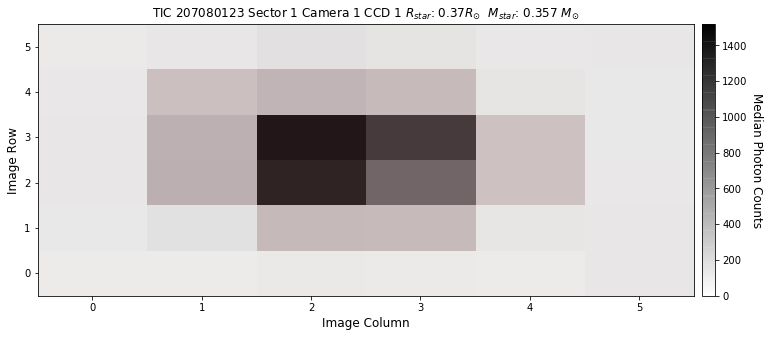

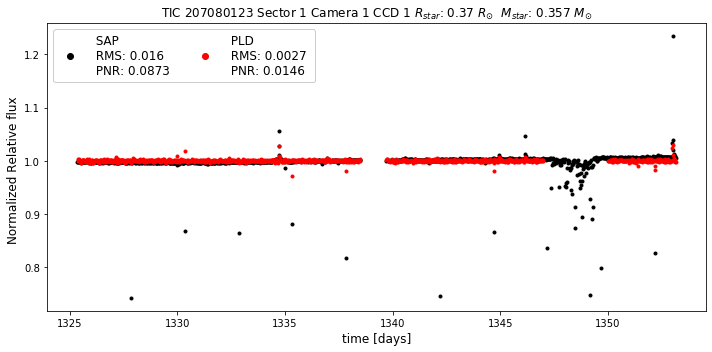

just detrended data


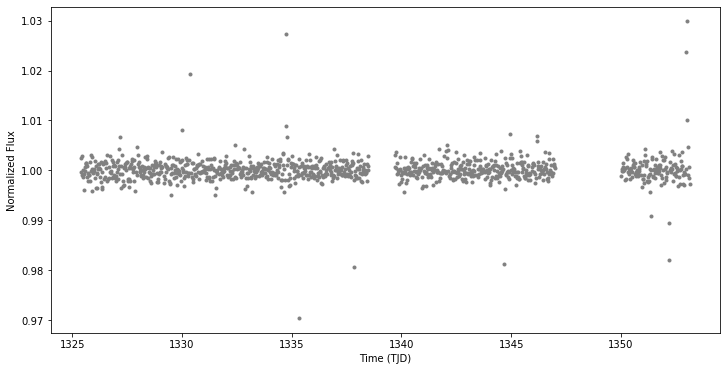

In [164]:
#Example Light Curve

ID=207080123
Sector=1
cutoutsize=6

raw_t, raw_f, det_t, det_f, det_e= PLD_FFI(ID,cutoutsize,Sector)

print('just detrended data')
plt.figure(figsize=(12,6))
plt.plot(det_t,det_f,color='grey',marker='.',linestyle='none')
plt.xlabel("Time (TJD)")
plt.ylabel('Normalized Flux')
plt.show()

# To feed in a list of TIC IDs, we can read in a list of targets and do a for loop to extract detrended light curves from each one and the results will save in 3 newly created directories in the location you ran this script from: 

## PLD_images, PLD_LCs and PLD_plots

Sector Number? (Ex: 1,2,3,...): 1
 
197598527
Star may not be M-type: too big!
 
129683871
Star may not be M-type: too big!
 
126910743


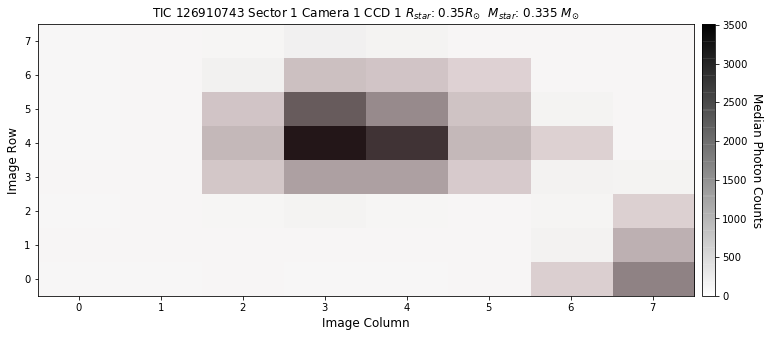

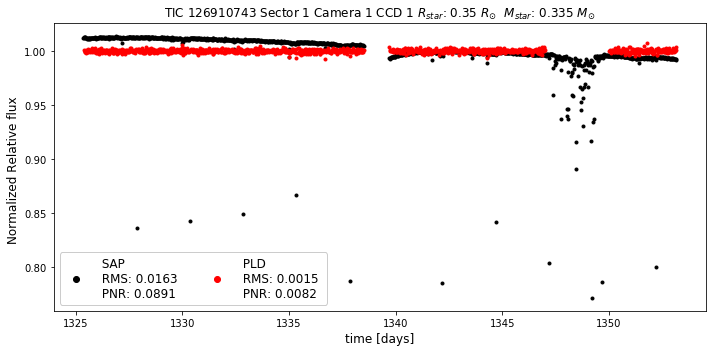

 
126909993
Star may not be M-type: too big!
 
165096625


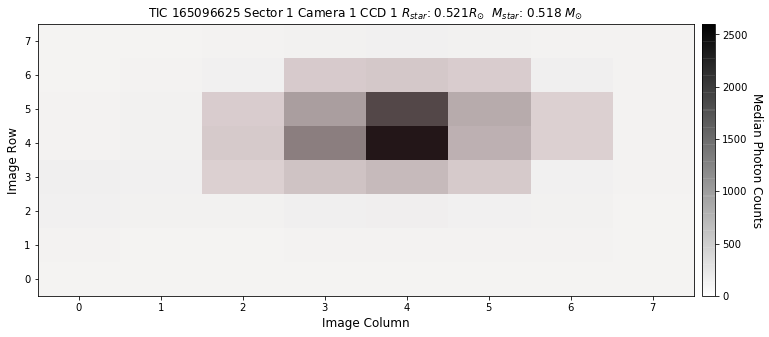

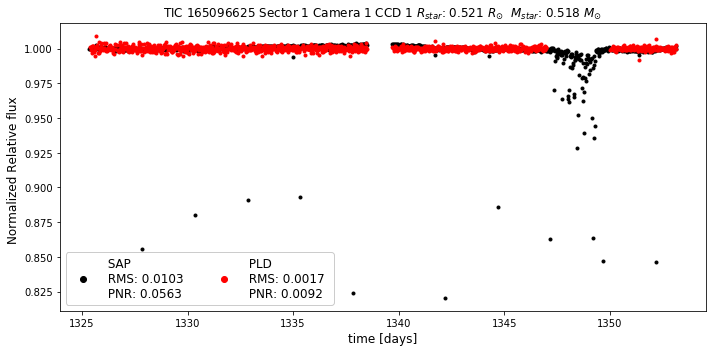

In [184]:
SectorNum = int(input("Sector Number? (Ex: 1,2,3,...): ") )

# text file with TIC IDs
# we don't need sector, ccd or camera info hence usecols=(0)
data=np.transpose(np.loadtxt("Sector"+str(SectorNum)+'.txt',usecols=(0))) 

print(" ")

cutoutsize=8
# for ii in range(len(data)): #for full data set
for ii in range(5): #for just a few data sets
    ID = int(data[ii])
    print(ID)
    raw_t, raw_f, det_t, det_f, det_e= PLD_FFI(ID,cutoutsize,SectorNum)
    print(" ")


# In the past, we determined a list of target stars for each TESS Sector. We can still use those. However, some were determined using the 7th version of the TESS Input Catalog (TIC). 

# In the current version (V8), stellar parameters like Radius, Mass and Temperature were updated. So some of our previous targets that we thought were M-dwarfs might not be with the current catalog...

# To tackle this problem, I think we can do use the Candidate Target List (CTL) at https://filtergraph.com/tess_ctl but this catalog doesn't include sector information for all target stars... 

# We could force a Sector check when running this code and just skip over some targets or do a very large radial search based on RA,DEC of where TESS is pointed to get more specific target lists per sector. 

# Stay tuned.